<a href="https://colab.research.google.com/github/Ashish-Tripathy/EIP/blob/master/EIP_A4_NewArch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2019-03-24 11:47:53--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  62.5MB/s    in 4.7s    

2019-03-24 11:48:03 (50.4 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
!unzip -q 'tiny-imagenet-200.zip'
!ls

sample_data  tiny-imagenet-200	tiny-imagenet-200.zip


In [0]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator



Using TensorFlow backend.


In [0]:
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
#each class in validation has 50 images each
print(val_data.head(3))
x = list(val_data['Class'].unique()[0:10])
val_data_red = val_data[val_data['Class'] .isin(x)]
val_data_red.Class.unique()

         File      Class
0  val_0.JPEG  n03444034
1  val_1.JPEG  n04067472
2  val_2.JPEG  n04070727


array(['n03444034', 'n04067472', 'n04070727', 'n02808440', 'n04399382',
       'n04179913', 'n02823428', 'n04146614', 'n02226429', 'n04371430'],
      dtype=object)

In [0]:
#!mkdir '/content/tiny-imagenet-200/tiny-imagenet-10'
!cp -r  '/content/tiny-imagenet-200/train/n03444034' '/content/tiny-imagenet-200/tiny-imagenet-10'
!cp -r  '/content/tiny-imagenet-200/train/n04067472' '/content/tiny-imagenet-200/tiny-imagenet-10'
!cp -r  '/content/tiny-imagenet-200/train/n04070727' '/content/tiny-imagenet-200/tiny-imagenet-10'
!cp -r  '/content/tiny-imagenet-200/train/n02808440' '/content/tiny-imagenet-200/tiny-imagenet-10'
!cp -r  '/content/tiny-imagenet-200/train/n04399382' '/content/tiny-imagenet-200/tiny-imagenet-10'
!cp -r  '/content/tiny-imagenet-200/train/n04179913' '/content/tiny-imagenet-200/tiny-imagenet-10'
!cp -r  '/content/tiny-imagenet-200/train/n02823428' '/content/tiny-imagenet-200/tiny-imagenet-10'
!cp -r  '/content/tiny-imagenet-200/train/n04146614' '/content/tiny-imagenet-200/tiny-imagenet-10'
!cp -r  '/content/tiny-imagenet-200/train/n02226429' '/content/tiny-imagenet-200/tiny-imagenet-10'
!cp -r  '/content/tiny-imagenet-200/train/n04371430' '/content/tiny-imagenet-200/tiny-imagenet-10'

In [0]:
!ls './tiny-imagenet-200/train/n01443537/images'

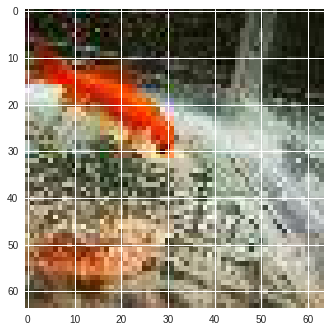

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_img = "tiny-imagenet-200/train/n01443537/images/n01443537_382.JPEG"
image = mpimg.imread(train_img)
plt.show()
plt.imshow(image)



# Using Image Data Generator for reading the scaled 32x32 images from the unzipped files

In [0]:
# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    #zoom_range = 0.3,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #rotation_range=40,
    #horizontal_flip=True
       
    )

valid_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/tiny-imagenet-10', target_size=(32, 32), color_mode='rgb', 
                                                    batch_size=200, class_mode='categorical', shuffle=True, seed=42)
train_generator

Found 5000 images belonging to 10 classes.


In [0]:
validation_generator = valid_datagen.flow_from_dataframe(val_data_red, directory='./tiny-imagenet-200/val/images', x_col='File', y_col='Class', target_size=(32, 32),
                                                    color_mode='rgb', class_mode='categorical', batch_size=20, shuffle=True, seed=42)
validation_generator

Found 500 images belonging to 10 classes.


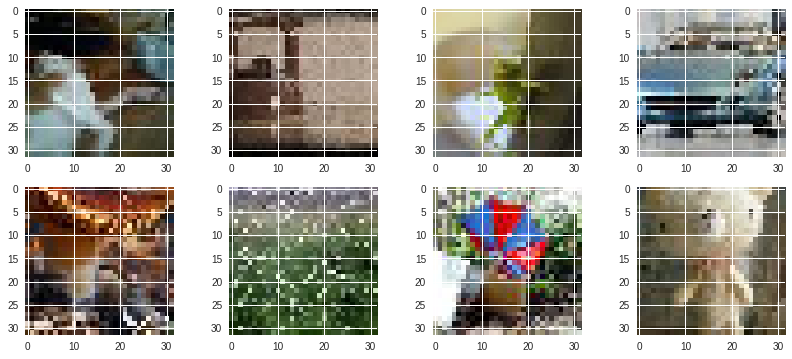

In [0]:
import matplotlib.pyplot as plt
x_batch, y_batch = next(train_generator)
fig = plt.figure(figsize=(14, 6))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(x_batch[i,:,:], interpolation='nearest')

# RESNET Code from Github

In [0]:
from __future__ import division

import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Dropout
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            
            input = block_function(filters=filters*(pow(2,i)), init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer))(input)
            
            input = Dropout(0.5)(input)
            
        input = _bn_relu_conv(filters=filters*2, kernel_size=(1, 1),
                                     strides=init_strides)(input)
        if is_first_layer:
          return input
        else:
          input = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(input)
          return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf

    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.

        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved

        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 =  Conv2D(filters=32, kernel_size=(7, 7),
                           strides=(1,1),
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        
        #pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = conv1
        filters = 32
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 3,3,2])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])


In [0]:
pow(2,0)

1

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

model = ResnetBuilder.build_resnet_34(input_shape = (3,32,32), num_outputs = 10)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
from keras import optimizers
adam = optimizers.Adam(lr = 0.001)
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr


lr_metric = get_lr_metric(adam)

model.compile(loss='categorical_crossentropy',
             optimizer=adam,
             metrics=['accuracy', lr_metric])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   4736        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation

In [0]:
from keras.callbacks import *

filepath="/content/gdrive/My Drive/Colab Notebooks/epochs_dropout:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.001)

       
callbacks_list = [checkpoint, reduce_lr]


TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size
VAL_STEP_SIZE = validation_generator.n//validation_generator.batch_size
model.fit_generator(train_generator, 
                    #initial_epoch = 53,
                    epochs=100,
                    steps_per_epoch = TRAIN_STEP_SIZE,
                    validation_steps=VAL_STEP_SIZE,
                    validation_data=validation_generator,
                    callbacks = callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
25/25 [==============================] - 58s 2s/step - loss: 3.7337 - acc: 0.1392 - lr: 0.0010 - val_loss: 3.7866 - val_acc: 0.1000 - val_lr: 0.0010

Epoch 00001: val_acc improved from -inf to 0.10000, saving model to /content/gdrive/My Drive/Colab Notebooks/epochs_dropout:001-val_acc:0.100.hdf5
Epoch 2/100
25/25 [==============================] - 35s 1s/step - loss: 3.5937 - acc: 0.1848 - lr: 0.0010 - val_loss: 4.4409 - val_acc: 0.1000 - val_lr: 0.0010

Epoch 00002: val_acc improved from 0.10000 to 0.10000, saving model to /content/gdrive/My Drive/Colab Notebooks/epochs_dropout:002-val_acc:0.100.hdf5
Epoch 3/100
25/25 [==============================] - 35s 1s/step - loss: 3.4279 - acc: 0.2180 - lr: 0.0010 - val_loss: 4.7527 - val_acc: 0.1000 - val_lr: 0.0010

Epoch 00003: val_acc did not improve from 0.10000
Epoch 4/100
25/25 [==============================] - 35s 1s/step - loss: 3.2519 - acc: 0.2550 - lr: 0.0010 - val_loss: 

KeyboardInterrupt: ignored

In [0]:
model.load_weights('/content/gdrive/My Drive/Colab Notebooks/epochs_dropout:039-val_acc:0.244.hdf5')

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [0]:

TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size
VAL_STEP_SIZE = validation_generator.n//validation_generator.batch_size
model.fit_generator(train_generator, 
                    initial_epoch = 50,
                    epochs=50,
                    steps_per_epoch = TRAIN_STEP_SIZE,
                    validation_steps=VAL_STEP_SIZE,
                    validation_data=validation_generator,
                    callbacks = callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 10/50
200/200 [==============================] - 139s 694ms/step - loss: 3.2302 - acc: 0.4660 - val_loss: 5.2531 - val_acc: 0.1999

Epoch 00010: val_acc improved from -inf to 0.19990, saving model to /content/gdrive/My Drive/Colab Notebooks/epochs:010-val_acc:0.200.hdf5
Epoch 11/50
200/200 [==============================] - 110s 548ms/step - loss: 2.8082 - acc: 0.5575 - val_loss: 5.6182 - val_acc: 0.1856

Epoch 00011: val_acc did not improve from 0.19990
Epoch 12/50
200/200 [==============================] - 111s 555ms/step - loss: 2.5504 - acc: 0.6148 - val_loss: 6.1096 - val_acc: 0.1827

Epoch 00012: val_acc did not improve from 0.19990
Epoch 13/50
200/200 [==============================] - 112s 558ms/step - loss: 2.3390 - acc: 0.6688 - val_loss: 6.1386 - val_acc: 0.1833

Epoch 00013: val_acc did not improve from 0.19990
Epoch 14/50
200/200 [==============================] - 111s 554ms/step - loss: 2.1745 - acc: 0.7122 - val_loss:

In [0]:
# Saving the model after 50 epochs trained on 32x32 image
model.save_weights("/content/gdrive/My Drive/Colab Notebooks/epochs:050-val_acc:0.18.hdf5")



Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


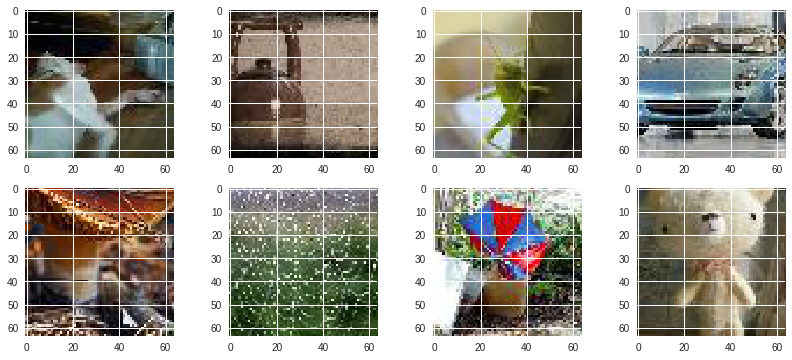

In [0]:
# Reading 64x64 image
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=500, class_mode='categorical', shuffle=True, seed=42)



validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images', x_col='File', y_col='Class', 
                                                         target_size=(64, 64), color_mode='rgb', class_mode='categorical', 
                                                         batch_size=500, shuffle=True, seed=42)


import matplotlib.pyplot as plt

x_batch, y_batch = next(train_generator)

fig = plt.figure(figsize=(14, 6))


for i in range(8):

    sub = fig.add_subplot(2, 

4, i + 1)

    sub.imshow(x_batch[i,:,:], interpolation='nearest')



In [0]:
model = ResnetBuilder.build_resnet_50(input_shape = (3,64,64), num_outputs = 200)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.load_weights('/content/gdrive/My Drive/Colab Notebooks/epochs_dropout:039-val_acc:0.244.hdf5')


OSError: ignored

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [0]:
from keras.callbacks import *

filepath="/content/gdrive/My Drive/Colab Notebooks/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

       
callbacks_list = [checkpoint, reduce_lr]


TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size
VAL_STEP_SIZE = validation_generator.n//validation_generator.batch_size
history = model.fit_generator(train_generator, 
                    initial_epoch = 50,
                    epochs=100,
                    steps_per_epoch = TRAIN_STEP_SIZE,
                    validation_steps=VAL_STEP_SIZE,
                    validation_data=validation_generator,
                    callbacks = callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 51/100
200/200 [==============================] - 262s 1s/step - loss: 4.7015 - acc: 0.2458 - val_loss: 4.7031 - val_acc: 0.2294

Epoch 00051: val_acc improved from -inf to 0.22940, saving model to /content/gdrive/My Drive/Colab Notebooks/epochs:051-val_acc:0.229.hdf5
Epoch 52/100
200/200 [==============================] - 236s 1s/step - loss: 3.7647 - acc: 0.3798 - val_loss: 4.4194 - val_acc: 0.2631

Epoch 00052: val_acc improved from 0.22940 to 0.26310, saving model to /content/gdrive/My Drive/Colab Notebooks/epochs:052-val_acc:0.263.hdf5
Epoch 53/100
200/200 [==============================] - 236s 1s/step - loss: 3.2593 - acc: 0.4745 - val_loss: 4.4432 - val_acc: 0.2814

Epoch 00053: val_acc improved from 0.26310 to 0.28140, saving model to /content/gdrive/My Drive/Colab Notebooks/epochs:053-val_acc:0.281.hdf5
Epoch 54/100
200/200 [==============================] - 236s 1s/step - loss: 2.8109 - acc: 0.5783 - val_loss: 4.8104 - va

KeyboardInterrupt: ignored

**Interupted the training as it seems to have hit local minima. Next planning to increase the learning rate for feaw initial epochs and train again from 53rd epoch.**

## Retraining from 54th Epoch with increased Learning Rate

In [0]:
model = ResnetBuilder.build_resnet_50(input_shape = (3,64,64), num_outputs = 200)
model.load_weights('/content/gdrive/My Drive/Colab Notebooks/epochs:052-val_acc:0.263.hdf5')


In [0]:
from keras import optimizers
adam = optimizers.Adam(lr = 0.001)
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr


lr_metric = get_lr_metric(adam)

model.compile(loss='categorical_crossentropy',
             optimizer=adam,
             metrics=['accuracy', lr_metric])

In [0]:
from keras.callbacks import *

filepath="/content/gdrive/My Drive/Colab Notebooks/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

       
callbacks_list = [checkpoint, reduce_lr]


TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size
VAL_STEP_SIZE = validation_generator.n//validation_generator.batch_size
model.fit_generator(train_generator, 
                    initial_epoch = 53,
                    epochs=100,
                    steps_per_epoch = TRAIN_STEP_SIZE,
                    validation_steps=VAL_STEP_SIZE,
                    validation_data=validation_generator,
                    callbacks = callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 54/100
 96/200 [=============>................] - ETA: 2:27 - loss: 3.1886 - acc: 0.4909 - lr: 0.0010